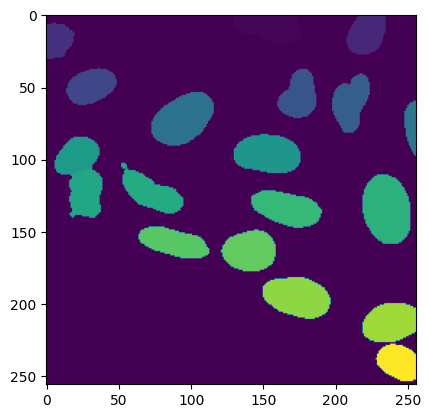

array([  0,   2,  13,  16,  24,  29,  34,  42,  45,  59,  61,  67,  69,
        72,  75,  83,  85,  93,  96, 112], dtype=uint8)

In [4]:
import numpy as np
import cv2

ins1 = np.load('/data1/zhangye/FCIS/data/BBBC006/data256/mmseg/fcis_inst/test/mcf-z-stacks-03212011_a04_s1_0.npy')
ins1.shape
plt.imshow(ins1)
plt.show()
np.unique(ins1)

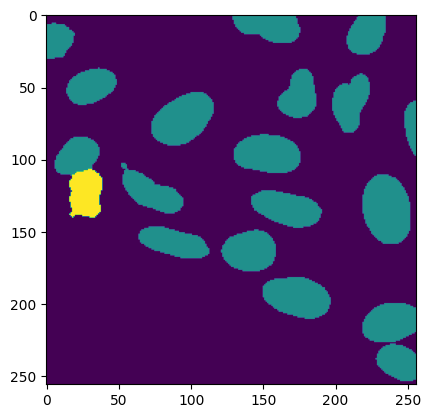

In [5]:
import cv2
import matplotlib.pyplot as plt

mask =  cv2.imread('/data1/zhangye/FCIS/data/BBBC006/data256/mmseg/fcis_inst/test/mcf-z-stacks-03212011_a04_s1_0.png', cv2.IMREAD_GRAYSCALE)
mask.shape
plt.imshow(mask)
plt.show()

In [15]:
import shutil

for i in range(2656,5179):
    shutil.copy(f'/data1/zhangye/FCIS/data/PanNuke/valid/{i}.png', f'/data1/zhangye/FCIS/data/PanNuke/data256/mmseg/images/val/{i}.png')

In [25]:
import shutil

for i in range(0, 2656):
    shutil.copy(f'/data1/zhangye/FCIS/data/PanNuke/train/{i}_instance.npy', f'/data1/zhangye/FCIS/data/PanNuke/data256/mmseg/fcis_inst/train/{i}.npy')
    

In [18]:
import shutil

for i in range(2656,5179):
    shutil.copy(f'/data1/zhangye/FCIS/data/PanNuke/valid/{i}_semantic.png', f'/data1/zhangye/FCIS/data/PanNuke/data256/mmseg/inst/val/{i}.png')
    

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from skimage import measure
from matplotlib import colors
import cv2
from tqdm import tqdm
import random

# Define the four colors (index 0 is background)
FOUR_COLORS = ['black', 'red', 'green', 'blue', 'yellow']

def create_adjacency_graph(label_img):
    """
    Create an adjacency graph based on a labeled instance image.
    Each node is a nucleus instance, and edges represent adjacency relationships.
    """
    regions = measure.regionprops(label_img)
    adjacency_graph = nx.Graph()

    for region in regions:
        adjacency_graph.add_node(region.label)

    for region in regions:
        coords = region.coords
        for y, x in coords:
            for dy, dx in [(-5, 0), (5, 0), (0, -5), (0, 5)]:
                ny, nx_ = y + dy, x + dx
                if 0 <= ny < label_img.shape[0] and 0 <= nx_ < label_img.shape[1]:
                    neighbor_label = label_img[ny, nx_]
                    if neighbor_label > 0 and neighbor_label != region.label:
                        adjacency_graph.add_edge(region.label, neighbor_label)

    return adjacency_graph

def color_cells(label_img, max_colors=4):
    """
    Apply greedy graph coloring to nuclei instances.
    Reassign nodes with colors >= max_colors randomly.
    """
    adjacency_graph = create_adjacency_graph(label_img)
    coloring = nx.coloring.greedy_color(adjacency_graph, strategy="largest_first")

    reassigned_count = 0
    for node, color_index in coloring.items():
        if color_index >= max_colors:
            coloring[node] = random.randint(0, max_colors - 1)
            reassigned_count += 1

    color_index_map = np.zeros(label_img.shape, dtype=np.uint8)
    for label, color_index in coloring.items():
        color_index_map[label_img == label] = color_index + 1  # 0 is background

    return color_index_map, reassigned_count

def visualize_color_map(color_index_map):
    """
    Generate a visualization image from the color index map.
    """
    cmap = colors.ListedColormap(FOUR_COLORS)
    norm = colors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], ncolors=5)
    return cmap(norm(color_index_map))

def process_all_datasets(input_root, output_root):
    """
    Traverse 'train', 'val', 'test' folders and apply four-color encoding.
    Save index maps and visualizations to output_root.
    """
    stages = ['val']
    total_reassigned = 0

    for stage in stages:
        input_dir = os.path.join(input_root, stage)
        save_dir = os.path.join(output_root, stage)
        visual_dir = os.path.join(output_root, stage, 'visual')

        os.makedirs(save_dir, exist_ok=True)
        os.makedirs(visual_dir, exist_ok=True)

        npy_files = [f for f in os.listdir(input_dir) if f.endswith('.npy')]

        for f in tqdm(npy_files, desc=f"Processing {stage}"):
            f_name = os.path.splitext(f)[0]
            label_img = np.load(os.path.join(input_dir, f)).astype(np.uint16)

            color_index_map, reassigned_count = color_cells(label_img)
            total_reassigned += reassigned_count

            # Save indexed color mask as grayscale PNG
            cv2.imwrite(os.path.join(save_dir, f"{f_name}.png"), color_index_map)

            # Save visualization as color PNG
            vis_img = visualize_color_map(color_index_map)
            plt.imsave(os.path.join(visual_dir, f"{f_name}.png"), vis_img)

    print(f"\n✅ Total reassigned cells across all datasets: {total_reassigned}")

# === Run this section below ===

input_dir = "/data1/zhangye/FCIS/data/PanNuke/data256/mmseg/inst"
output_dir = "/data1/zhangye/FCIS/data/PanNuke/data256/mmseg/fcis_inst"

process_all_datasets(input_dir, output_dir)



Processing val: 100%|██████████| 2523/2523 [07:21<00:00,  5.71it/s]


✅ Total reassigned cells across all datasets: 0


In [21]:
import os
import numpy as np
from skimage import measure
import networkx as nx
import yaml
from tqdm import tqdm

def create_adjacency_graph(label_img):
    """
    Create an adjacency graph based on a labeled instance image.
    Each node is a nucleus instance, and edges represent adjacency relationships.
    """
    regions = measure.regionprops(label_img)
    adjacency_graph = nx.Graph()

    for region in regions:
        adjacency_graph.add_node(region.label)

    for region in regions:
        coords = region.coords
        for y, x in coords:
            for dy, dx in [(-5, 0), (5, 0), (0, -5), (0, 5)]:
                ny, nx_ = y + dy, x + dx
                if 0 <= ny < label_img.shape[0] and 0 <= nx_ < label_img.shape[1]:
                    neighbor_label = label_img[ny, nx_]
                    if neighbor_label > 0 and neighbor_label != region.label:
                        adjacency_graph.add_edge(region.label, neighbor_label)

    return adjacency_graph

def save_adjacency_map_to_yaml(graph, file_path):
    """
    Save a networkx graph as an adjacency map to YAML.
    
    Args:
        graph (networkx.Graph): The graph representing adjacency relationships.
        file_path (str): Path to save the YAML file.
    """
    adjacency_map = {int(node): list(map(int, graph.neighbors(node))) for node in graph.nodes}
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'w') as f:
        yaml.dump(adjacency_map, f, default_flow_style=False, sort_keys=False)

# === Input and Output Paths ===
inst_root = "/data1/zhangye/FCIS/data/PanNuke/data256/mmseg/inst"
save_root = "/data1/zhangye/FCIS/data/PanNuke/data256/mmseg/adjacency"
stages = ['val']

# === Process All Files ===
for stage in stages:
    input_dir = os.path.join(inst_root, stage)
    output_dir = os.path.join(save_root, stage)
    os.makedirs(output_dir, exist_ok=True)

    file_list = [f for f in os.listdir(input_dir) if f.endswith(".npy")]

    for f in tqdm(file_list, desc=f"Processing {stage}"):
        f_name = os.path.splitext(f)[0]
        # print('f name', f_name)
        mask = np.load(os.path.join(input_dir, f)).astype(dtype=np.uint16)
        # print(mask)
        graph = create_adjacency_graph(mask)
        output_file = os.path.join(output_dir, f"{f_name}.yaml")
        save_adjacency_map_to_yaml(graph, output_file)

print("✅ All adjacency maps saved successfully.")



Processing val:   0%|          | 0/2523 [00:00<?, ?it/s]

Processing val: 100%|██████████| 2523/2523 [07:06<00:00,  5.91it/s]

✅ All adjacency maps saved successfully.


In [6]:
import os

def generate_file_list(directory, output_txt):
    """
    Generate a text file containing the file names (without extensions)
    of all files in a directory.

    Args:
        directory (str): Path to the directory containing the files.
        output_txt (str): Path to the output text file.
    """
    # Ensure the output directory exists before writing the file
    output_dir = os.path.dirname(output_txt)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    try:
        # Check if the source directory exists
        if not os.path.exists(directory):
            print(f"Warning: Source directory not found: {directory}. Skipping.")
            return

        # List all entries in the directory
        entries = os.listdir(directory)

        # Filter out directories and get only files
        files = [entry for entry in entries if os.path.isfile(os.path.join(directory, entry))]

        # Extract file names without extensions
        file_names = [os.path.splitext(file)[0] for file in files]

        # Write file names to the output text file
        with open(output_txt, 'w') as f:
            for name in file_names:
                f.write(name + '\n')

        print(f"File list saved successfully to {output_txt}")

    except Exception as e:
        print(f"An error occurred while processing {directory}: {e}")

if __name__ == "__main__":
    # Define the splits
    splits = ['test']

    # Define the base directory where the image folders for splits are located
    base_image_directory = "/data1/zhangye/FCIS/data/PanNuke/data256/mmseg/images"

    # Define the base directory where the output text files should be saved
    base_output_directory = "/data1/zhangye/FCIS/data/PanNuke/data256/mmseg"

    # Loop through each split and generate the corresponding text file
    for split in splits:
        # Construct the full path to the image directory for the current split
        image_directory_split = os.path.join(base_image_directory, split)

        # Construct the full path for the output text file for the current split
        output_file_split = os.path.join(base_output_directory, f"{split}.txt")

        print(f"Generating file list for split: {split}")

        # Call the function to generate the file list for the current split
        generate_file_list(image_directory_split, output_file_split)

    print("All file lists generated.")

Generating file list for split: test
File list saved successfully to /data1/zhangye/FCIS/data/PanNuke/data256/mmseg/test.txt
All file lists generated.
